In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# экран 50x50 mm (но выражено в метрах)
lx = 5e-3
ly =  5e-3

Nx = 500
Ny = 500

x = np.linspace(-lx / 2, lx / 2, Nx)
y = np.linspace(-ly / 2, ly / 2, Ny)
x_grid, y_grid = np.meshgrid(x, y)

In [ ]:
# длина волны
lam = 630 * 1e-9
# волновой коэффициент
k = 2 * np.pi / lam
# координаты линзы
x_am, y_am = 0, 0
# радиус кривизны линзы m
R = 1.35
# показатель преломления
n = 1
# Координата сферического источника
r0 = np.array([-1e-3, 1e-3, -4e-3])

In [ ]:
def plane_wave(z: float, x: np.ndarray, y: np.ndarray, k: np.array, amplitude:float = 1.):
    k_x = k[0]
    k_y = k[1]
    k_z = k[2]
    return amplitude * np.exp(1j * (k_x * x + k_y * y + k_z * z))


def spherical_wave(r0, x, y, k, amplitude=1):
    r = np.sqrt((x-r0[0])**2 + (y-r0[1])**2 + r0[2]**2)
    return amplitude*np.exp(1j * k * r)/r

def propagation(E, z, k = k):
     E_spatial = np.fft.fft2(E)
     kx = np.fft.fftfreq(E.shape[0])
     ky = np.fft.fftfreq(E.shape[1])
     KX, KY = np.meshgrid(kx, ky)
     phase = np.sqrt(k**2 - KX**2 - KY**2 + 0j) * z
     E_spatial_prop = E_spatial * np.exp(1j * phase)
     E_prop = np.fft.ifft2(E_spatial_prop)
     return E_prop

In [ ]:
def z(coord_x, coord_y, x_am, y_am, R_am=R):
  # расстояние до оптического центра линзы
  sq_r = (coord_x - x_am) ** 2 + (coord_y - y_am) ** 2
  # выразим изменение по z
  delta_z = sq_r / (2 * R_am)
  return delta_z


# изменение фазы
def delta_phi(coord_x, coord_y, k, x_am, y_am, R_am=R, n=1):
  # изменение по z
  delta_z = z(coord_x, coord_y, x_am, y_am, R_am)
  # еще по идее есть множитель (n - 1)
  delta_phi = k * delta_z * (n-1)
  return delta_phi


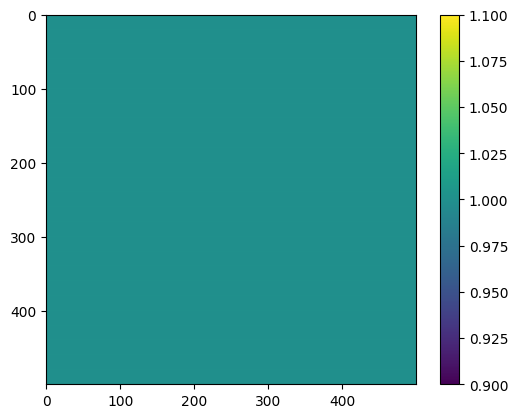

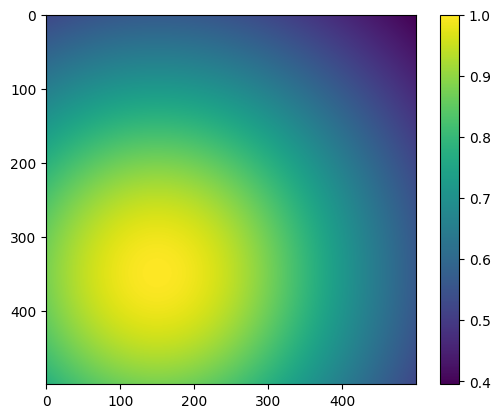

In [ ]:
k_vec = k * np.array([0, 0, 1])
E0 = plane_wave(0, x_grid, y_grid, k_vec)
E1 = spherical_wave(r0 , x_grid, y_grid, k)
# фазовая маска
test_phi = delta_phi(x_grid, y_grid, k, x_am, y_am)
E = E0 * np.exp(1j * test_phi)
E_prop = propagation(E, z=1e-2)
I0 = np.abs(E_prop * np.exp(1j * np.pi)) ** 2
I1 = np.abs(E1) ** 2

# for plane wave
plt.imshow(I0/np.max(I0))
plt.colorbar()
plt.show()

# for spherical wave
plt.imshow(I1/np.max(I1))
plt.colorbar()
plt.show()

In [ ]:
from tqdm import tqdm
# Расстояние до пластинки
d = 0
# Коэффициент отражения пластинки
Reflect = 0.5
# Количество переотражений через которое поле упадет в 100 раз
N = int(np.log(1e-3)/np.log10(abs(Reflect)**2))+1
# Здесь будем считать суммарное поле на пластинке
E_tot = np.zeros_like(E0)
E_prop = E1 * np.exp(1j * delta_phi(x_grid, y_grid, k, x_am, y_am, n = 1.5))
# tqdm создает progress bar
for _ in tqdm(range(N)):
    # Распространяем до пластинки
    #E_prop = propagation(E_prop, d)
    # Добавляем поле к полю на пластинке
    E_tot += E_prop
    # Отражаем волну обратно, считая что коэффиент отражения R
    E_prop = E_prop * Reflect
    # распространяем поле до обратно до линзы на -d: (-k_z * -d = k_z * d)
    #E_prop = propagation(E_prop, d)
    # умножаем на фазовую маску линзы
    E_prop *= np.exp(1j * delta_phi(x_grid, y_grid, k, x_am, y_am, n = -1))
    # Отражаем
    E_prop = -E_prop * Reflect

# Бим бим бам бам добавляем решение Даши из методички
def Newtons_ring(R, lamda):
  r=np.sqrt((x_grid-x_am)**2+(y_grid-y_am)**2)#расстояние до центра
  d=(r**2)/(2*R)#Расстояние между линзой и поверхностью
  delta=2*d+(lam/2)#разность хода
  delta_fi=(2*np.pi/lam)*delta#разность фаз
  I=np.abs(np.cos(delta_fi/2))**2
  return I

I_theory = Newtons_ring(R=1.35,lamda=578*10**-7)
I_test = np.abs(E_tot) ** 2/np.max(np.abs(E_tot))**2



100%|██████████| 12/12 [00:00<00:00, 53.87it/s]


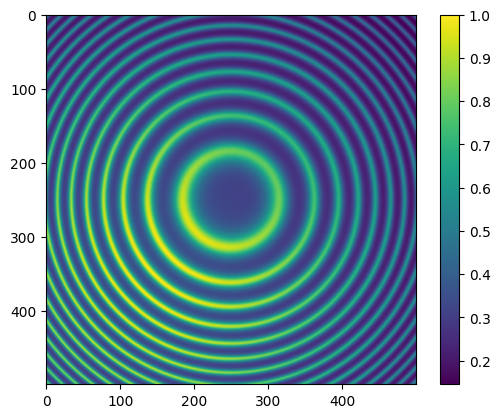

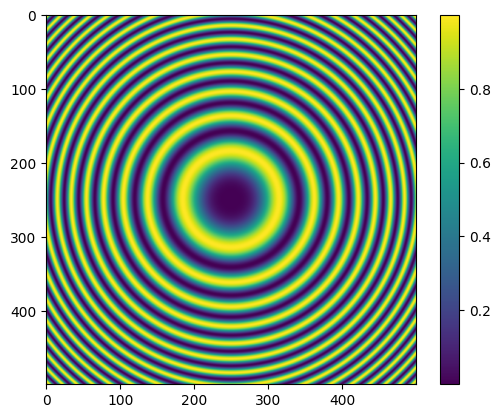

In [ ]:
# Сравниваем наше с тем что у Даши
plt.imshow(I_test)
plt.colorbar()
plt.show()
plt.imshow(I_theory)
plt.colorbar()
plt.show()

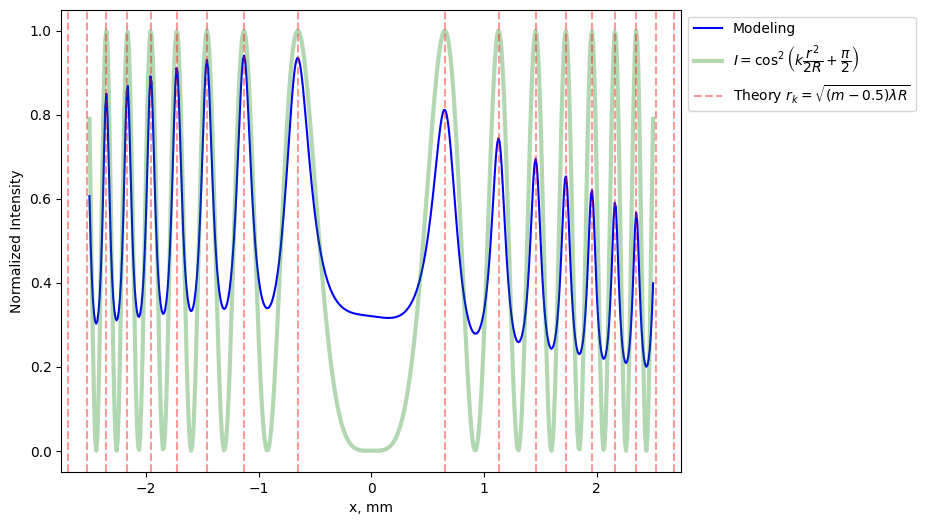

In [ ]:
# Нарисуем горизонтальный срез интенсивности

# Сравниваем с навикипеженной формулой для колец Ньютона
plt.figure(figsize = (8, 6))
plt.plot(x*1e3, I_test[Nx//2], color = 'blue')
plt.plot(x*1e3, I_theory[Nx//2], color = 'green', linewidth = 3, alpha = 0.3)
plt.xlabel('x, mm')
plt.ylabel('Normalized Intensity')

# Нарисуем теоретические значения радиусов колец ньютона
n = 10
for i in range(1, 10):
    r = np.sqrt((i-1/2)*lam*R)
    plt.axvline(r*1e3, color = 'red', linestyle = '--', alpha = 0.4)
    plt.axvline(-r*1e3, color = 'red', linestyle = '--', alpha = 0.4)
plt.legend(['Modeling', r'$I = \cos^2\left(k\dfrac{r^2}{2R} + \dfrac{\pi}{2}\right)$', r'Theory $r_k=\sqrt{(m-0.5)\lambda R}$'], bbox_to_anchor = [1, 1])
plt.show()